
    
# Маркетинговый анализ развлекательного приложения Procrastinate Pro+ 


##  Загрузка и предобработка данных 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime, timedelta
import numpy as np

In [2]:
visits=pd.read_csv('/datasets/visits_info_short.csv')
orders=pd.read_csv('/datasets/orders_info_short.csv')
costs=pd.read_csv('/datasets/costs_info_short.csv')

In [3]:
visits.columns=visits.columns.str.lower()
visits= visits.rename(columns={'user id': 'user_id',
                               'session start': 'session_start',
                               'session end': 'session_end'})

print('Количество явных дубликатов в данных:',
      visits.duplicated(subset=['user_id',
                                'session_start',
                                'session_end']).sum())


print('Уникальные значения в названиях стран:',
      visits['region'].sort_values().unique())
print('Уникальные значения в названиях устройств:',
      visits['device'].sort_values().unique())
print('Уникальные значения в названиях устройств:',
      visits['channel'].sort_values().unique())   

Количество явных дубликатов в данных: 0
Уникальные значения в названиях стран: ['France' 'Germany' 'UK' 'United States']
Уникальные значения в названиях устройств: ['Android' 'Mac' 'PC' 'iPhone']
Уникальные значения в названиях устройств: ['AdNonSense' 'FaceBoom' 'LeapBob' 'MediaTornado' 'OppleCreativeMedia'
 'RocketSuperAds' 'TipTop' 'WahooNetBanner' 'YRabbit' 'lambdaMediaAds'
 'organic']


In [4]:
visits['region']=visits['region'].replace("United States", "USA")
print('Уникальные значения в названиях стран:',
      visits['region'].sort_values().unique())

Уникальные значения в названиях стран: ['France' 'Germany' 'UK' 'USA']


In [5]:
orders.columns=orders.columns.str.lower()
orders= orders.rename(columns={'user id': 'user_id',
                               'event dt': 'event_dt'})
print('Количество явных дубликатов в данных:', orders.duplicated().sum())

Количество явных дубликатов в данных: 0


In [6]:
costs.columns=costs.columns.str.lower()

print('Количество явных дубликатов в данных:',
      costs.duplicated().sum())

Количество явных дубликатов в данных: 0


In [7]:
visits['session_start']=pd.to_datetime(visits['session_start'])
visits['session_end']=pd.to_datetime(visits['session_end'])
orders['event_dt']=pd.to_datetime(orders['event_dt'])
costs['dt']=pd.to_datetime(costs['dt']).dt.date


## Функции для расчета и анализа LTV, ROI, удержания и конверсии



### Функция для построения профилей

In [8]:
def get_profiles(visits, orders, costs):
    profiles = (
        visits.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )
    profiles['dt'] = pd.to_datetime(profiles['first_ts']).dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

       
    new_users = (profiles.groupby(['dt', 'channel']).
                 agg({'user_id': 'nunique'})
                 .rename(columns={'user_id': 'unique_users'})
                 .reset_index()
                )

    costs = costs.merge(new_users, on=['dt', 'channel'], how='left')
    costs['acquisition_cost'] = costs['costs'] / costs['unique_users']
    profiles = profiles.merge(
        costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    return profiles


### Функция для расчета коэффициента удержания 'Retention Rate'

In [9]:

def get_retention(profiles, sessions, observation_date, horizon_days, dimensions = [], ignore_horizon = False):
    
   
    dimensions = ['payer'] + dimensions
    
    # оттсекаем всех пользователей, которые не могли "дожить" до нужного горизонта 
    # (присоединились позже чем observation_date - horizon)
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days = horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # формируем массив сырых данных
    result_raw = result_raw.merge(sessions[['user_id', 'session_start']], on = 'user_id', how = 'left')
    result_raw['lifetime'] = (result_raw['session_start'] - result_raw['first_ts']).dt.days
    
    # функция группировки по нужному набору измерений
    def group_by_dimensions(df, dims, horizon_days):     
        result = df.pivot_table(index = dims, columns = 'lifetime', values = 'user_id', aggfunc = 'nunique')     
        cohort_sizes = df.groupby(dims).agg({'user_id': 'nunique'}).rename(columns = {'user_id': 'cohort_size'}) 
        result = cohort_sizes.merge(result, on = dims, how = 'left').fillna(0)                                   
        result = result.div(result['cohort_size'], axis = 0)                                                     
        result = result[['cohort_size'] + list(range(horizon_days))]                                            
        return result
    
    # расчитываем удержание 
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    
    # рассчитываем удержание по всем параметрам + дата
    result_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)
    
    # возвращаем и таблицы удержания и сырые данные (чтобы в случае чего можно было в них покопаться при отладке)
    return result_raw, result_grouped, result_in_time


def ret(x):
    retention_raw, retention, retention_history = get_retention(
    profiles, visits, observation_date, 14, dimensions=[x]
    )
    plt.figure(figsize=(20, 6)) # задаём размер сетки для графиков

    for i, payer in enumerate(profiles['payer'].unique()):
        sns.heatmap(
        retention.query('payer == @payer')
        # удаляем payer из индексов, чтобы не загромождать графики
        .droplevel('payer')
        # исключаем размеры когорт и удержание первого дня
        .drop(columns=['cohort_size', 0]),
        # добавляем подписи значений
        annot=True,
        # переводим значения в проценты
        fmt='.2%',
        # строим каждый график в своей ячейке
        ax=plt.subplot(1, 2, i + 1),
        )
        # задаём названия графиков с учётом значения payer
        plt.title('Тепловая карта удержания для payer = {}'.format(payer))

        plt.tight_layout()  # «подгоняем» размер графиков, чтобы уместились подписи
       
    

    
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в четвёртой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()


### Функция для расчета конверсии 'Conversion Rate'

In [10]:
def get_conversion(
    profiles,
    visits,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        orders.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу конверсии
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        # считаем сумму с накоплением для каждой строки
        result = result.fillna(0).cumsum(axis = 1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # добавляем размеры когорт в таблицу конверсии
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()



<a id='24'></a>
### Функция для расчета LTE и ROI

In [11]:
def get_ltv(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    result_raw = result_raw.merge(
        orders[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )
        roi = result.div(cac['cac'], axis=0)
        roi = roi[~roi['cohort_size'].isin([np.inf])]
        roi['cohort_size'] = cohort_sizes
        roi['cac'] = cac['cac']
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]
        return result, roi

    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )
    if 'cohort' in dimensions:
        dimensions = []
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )


def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения 
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()


## Исследовательский анализ данных

- Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
- Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
- По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

<a id='31'></a>
### Строим профили посетителей

In [12]:
profiles = get_profiles(visits, orders, costs)

min_date = profiles['dt'].min()
max_date = profiles['dt'].max()
print('Минимальная дата привлечения:', min_date, 
     '\nМаксимальная дата привлечения:', max_date)


Минимальная дата привлечения: 2019-05-01 
Максимальная дата привлечения: 2019-10-27


#### Распределение посетителей по источникам привлечения

Оценим количество привлечённых каждым источником посетителей. Для этого напишем функцию в которой сгруппируем  профили по рекламному каналу (другому признаку) и посчитаем количество уникальных пользователей. Для снижения "визуального шума" отфильтруем данные перед тем, как построим график. 

,channel,user_id,payer
0,organic,56439,0.020553
1,FaceBoom,29144,0.122049
2,TipTop,19561,0.096007
3,OppleCreativeMedia,8605,0.027077
4,LeapBob,8553,0.030633
5,WahooNetBanner,8553,0.052964
6,RocketSuperAds,4448,0.079137
7,MediaTornado,4364,0.035747
8,YRabbit,4312,0.038265
9,AdNonSense,3880,0.113402


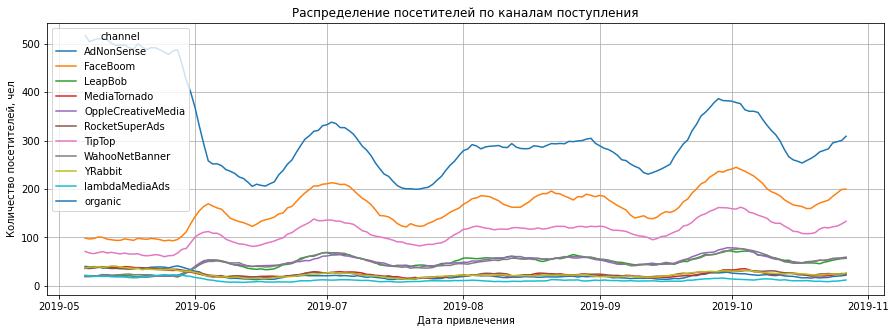

In [13]:
def filter_data(df, window):
    
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

window=7

def sign (x, y):
    a=(
        profiles.groupby(x).agg({'user_id': 'nunique',
                                 'payer': 'mean'})
        .sort_values(by='user_id', ascending=False)
        )    
    filtered_data=profiles.pivot_table(
    index='dt',  # даты первых посещений
    columns=x,  # признак
    values='user_id',  # ID пользователей
    aggfunc='nunique'  # подсчёт уникальных значений
    )
    a=a.reset_index()
   
    display(a)
    filter_data(filtered_data, window).plot(figsize=(15, 5), grid=True)
    plt.xlabel('Дата привлечения')  # название оси X
    plt.ylabel('Количество посетителей, чел') 
    plt.title(y)
    return plt.show()

sign ('channel', 'Распределение посетителей по каналам поступления')




**Вывод** Как мы видим, за весь период наблюдения основным источником привлечения являлся 'organic', при этом наибольшее количество пользоватей из этого источника было привлечено в мае 2016 года. На втором и третьем местах по количеству привлеченных пользователей - 'FaceBoom'  и 'TipTop'  соответсвенно. При этом динамика привлечения пользователей по этим двум источникам схожа, рост количества привлеченных пользователей начинает увеличиваться с июня 2019 года и далее находится примерно на одном уровне. По доле покупателей из общего  числа пользователей на первом месте FaceBoom (12% покупателей из всех посетителей), AdNonSense - 11%, lambdaMediaAds- 10%, TipTop -9,6%. Но говорить по экстенсивным показателям какой из источников приносит больше покупателей нельзя. Посчитаем количество покупателей по каждому источнику привлечения.

Оценим распреление по источникам привлечения только тех посетителей, которые стали покупателями. Для этого напишем аналогичную функцию, только для посетителей со значением 'payer'=True

,channel,user_id
0,FaceBoom,3557
1,TipTop,1878
2,organic,1160
3,WahooNetBanner,453
4,AdNonSense,440
5,RocketSuperAds,352
6,LeapBob,262
7,OppleCreativeMedia,233
8,lambdaMediaAds,225
9,YRabbit,165


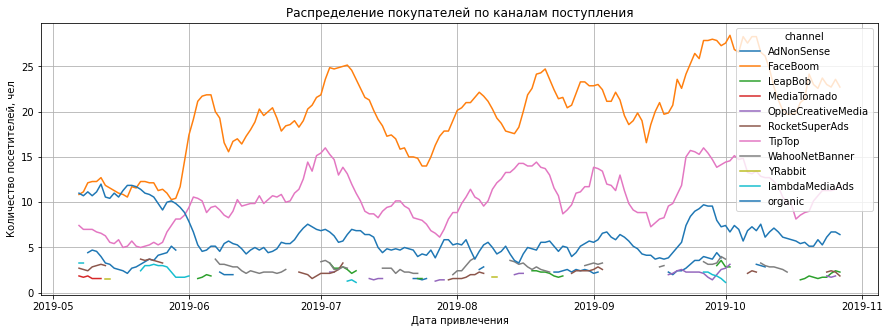

In [14]:
payers= profiles.query('payer==True')
def sign_payer (x, y):
    a=(
        payers.groupby(x).agg({'user_id': 'nunique'})
        .sort_values(by='user_id', ascending=False)
        )  
    filtered_data=payers.pivot_table(
    index='dt',  # даты первых посещений
    columns=x,  # признак
    values='user_id',  # ID пользователей
    aggfunc='nunique'  # подсчёт уникальных значений
    )
    a=a.reset_index()
    
    display(a)
    filter_data(filtered_data, window).plot(figsize=(15, 5), grid=True)
    plt.xlabel('Дата привлечения')  # название оси X
    plt.ylabel('Количество посетителей, чел') 
    plt.title(y)
    return plt.show()




sign_payer ('channel', 'Распределение покупателей по каналам поступления')

**Вывод** Основной источник привлечения **покупателей** - 'FaceBoom' (40% от всех привлеченных покупателей), при этом количество привлеченных покупателей начинает увеличиваться с июня 2019 года. На втором месте по количеству привлеченных покупателей 'TipTop' (21% от всех привлеченных покупателей)- наибольший рост количества привлеченных покупателей приходится на сентябрь 2019 года. По этим двум источникам мы также видим некоторое снижение привлечения в июле 2019 года. На третьем месте 'organic' - 13,1% от всех привлеченных покупателей.

#### Распределение посетителей по странам

Аналогично оценим распределение посетителей и покупателей по странам. 

,region,user_id,payer
0,USA,100002,0.069019
1,UK,17575,0.039829
2,France,17450,0.037994
3,Germany,14981,0.041119


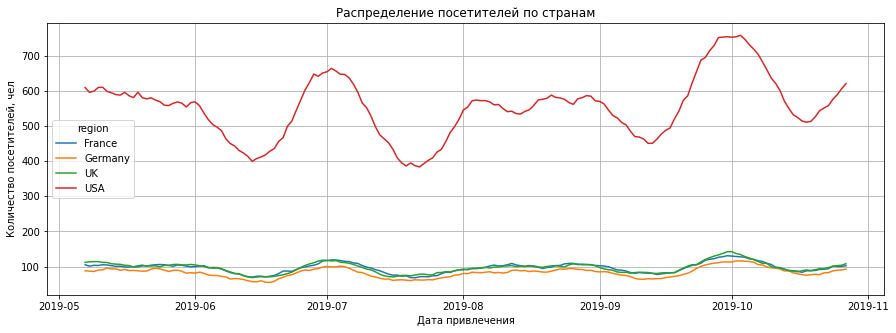

In [15]:
sign ('region', 'Распределение посетителей по странам')

**Вывод** Наибольшее количество посетителей проживает в их количество значительно превышает количество посетителей из других стран (более чем в 5 раз). Количество посетителей из Великобритании, Франции  и Германии  примерно равно. В США - покупателями становятся 7% посетителей, в странах Европы (Великобритании, Франции  и Германии) эти показатели примерно равны и составляют около 4%.  

,region,user_id
0,USA,6902
1,UK,700
2,France,663
3,Germany,616


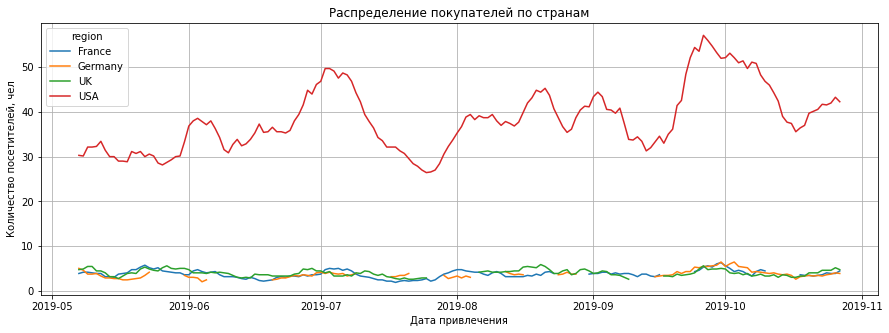

In [16]:
sign_payer('region', 'Распределение покупателей по странам')

**Вывод:** Картина распределения покупателей по странам схожа с картиной распределения посетителей. Наибольшее количество покупателей  проживает в США (77,7%). 

#### Распределение посетителей в зависимости от вида устройства с которого они совершают вход и покупки. 

,device,user_id,payer
0,iPhone,54479,0.062079
1,Android,35032,0.058518
2,PC,30455,0.050468
3,Mac,30042,0.063644


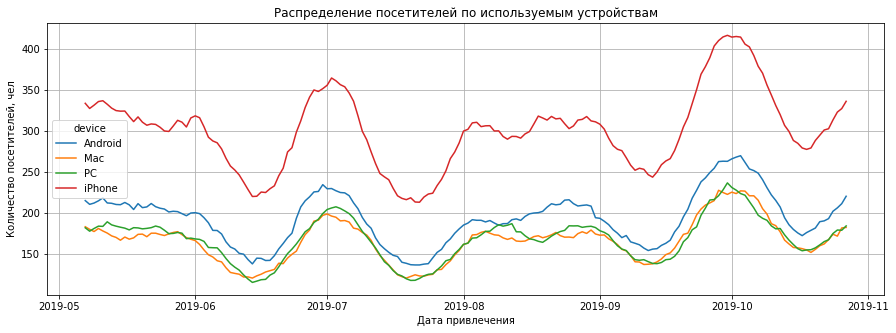

In [17]:
sign('device', 'Распределение посетителей по используемым устройствам')

**Вывод:** Наибольшее количество пользователей используют для входа 'iPhone' . Количество посетителей, испольщующих 'Mac', 'PC', 'Android' примерно равно. Среди пользователей PC покупателями становятся 5% посетителей. Среди пользователей Mac, iPhone, Android покупателями становятся около 6% посетителей.

,device,user_id
0,iPhone,3382
1,Android,2050
2,Mac,1912
3,PC,1537


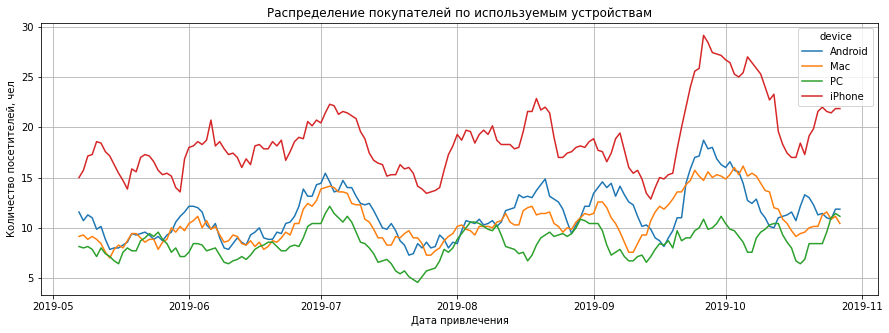

In [18]:
sign_payer('device', 'Распределение покупателей по используемым устройствам')

**Вывод** Количество **покупателей** использующих для покупок 'iPhone' больше, чем пользователей использующих другие устройства, Количество покупателей, испольщующих 'Mac', 'PC', 'Android' примерно равно.  

## Маркетинг


In [19]:
print('Всего за период наблюдения было потрачено на рекламу:',
      costs['costs'].sum().astype('int'))

Всего за период наблюдения было потрачено на рекламу: 105497


Для оценки трат на каждый источник привлечения сгруппируем данные по источнику и посчитаем общее количество затраченных средств. 

In [20]:

n=(costs.groupby('channel')
   .agg({'costs': 'sum'})
   .sort_values(by='costs'
                , ascending=False)
   .reset_index()
  )
display(n)
n=n.loc[0:1,'costs'].sum()/n['costs'].sum()*100

print(f'Доля рекламного бюджета потраченная на площадках TipTop и FaceBoom: {n:.0f}%')  

,channel,costs
0,TipTop,54751.30
1,FaceBoom,32445.60
2,WahooNetBanner,5151.00
3,AdNonSense,3911.25
4,OppleCreativeMedia,2151.25
5,RocketSuperAds,1833.00
6,LeapBob,1797.60
7,lambdaMediaAds,1557.60
8,MediaTornado,954.48
9,YRabbit,944.22


Доля рекламного бюджета потраченная на площадках TipTop и FaceBoom: 83%


**Вывод** Наибольшая сумма была вложена в рекламу на площадке TipTop, на втором месте по затратам FaceBoom. На рекламу на этих двух площадках было потрачено более 80% всего рекламного бюджета.  

Оценим траты на рекламу по дням:


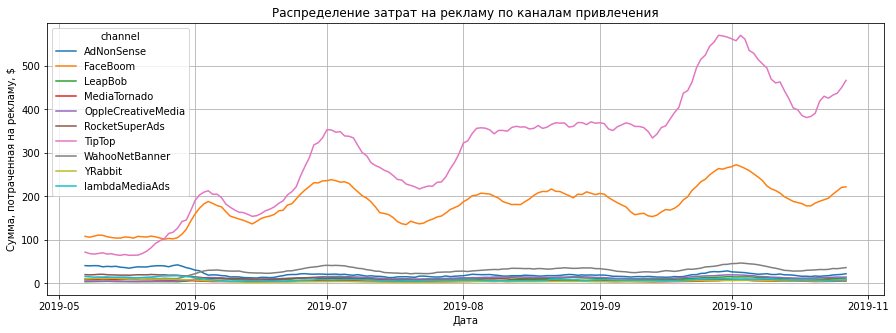

In [21]:
n=(
    costs.groupby(['channel', 'dt'],  axis=0)
    .agg({'costs': 'sum'})
    .sort_values(by='dt'
                 , ascending=False)
    .reset_index()
    ) 
filtered_data=n.pivot_table(
    index='dt',  
    columns='channel',  
    values='costs',  
    aggfunc='sum'  
    )
filter_data(filtered_data, window).plot(figsize=(15, 5), grid=True)
plt.xlabel('Дата')  # название оси X
plt.ylabel('Сумма, потраченная на рекламу, $') 
plt.title('Распределение затрат на рекламу по каналам привлечения')
plt.show()
 

**Вывод:** Как мы уже выяснили ранее, наибольшие траты пришлись на рекламу на площадках TipTop и FaceBoom. В течение периода наблюдения траты распределены неравномерно. Так мы видим, увеличение вложений в рекламу на площадках TipTop и FaceBoom происходило 'параллельно' и началось с июня 2019 года, достигнув максимума в начале октября с последующим небольшим снижением. 

Для расчета CAC (Customer Aqcuisition Cost)  

[Воспользуемся функцией get_ltv](#24)


Перед расчетом показателей установим горизонт наблюдений - 14 дней, определим последнюю дату наблюдения, как максимальную дату привлечения. 

In [22]:
observation_date=datetime(2019,11,1).date()
print(observation_date)


2019-11-01


In [23]:
profiles = get_profiles(visits, orders,  costs)
result_raw, result_grouped, result_in_time, roi_grouped, roi_in_time = get_ltv(
  profiles,
  orders,
  observation_date,
  14,
  dimensions=[],
  ignore_horizon=False)

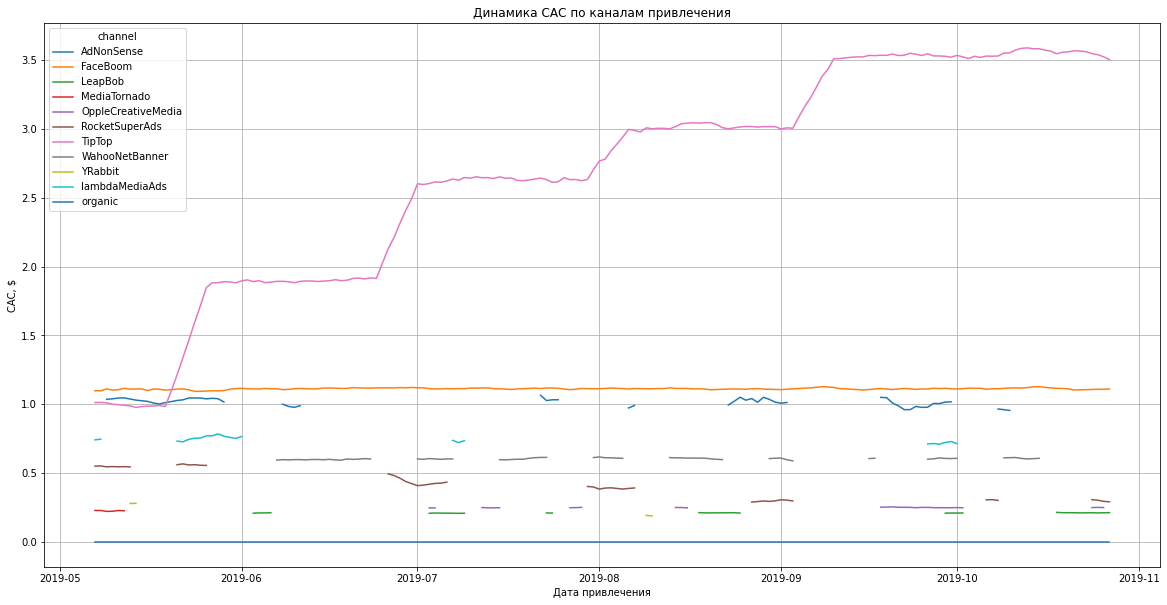

In [24]:
filtered_data=profiles.query('payer==True').pivot_table(
    index='dt',
    columns='channel',
    values='acquisition_cost',
    aggfunc='mean'
)


filter_data(filtered_data, window).plot(figsize=(20, 10), grid=True)
plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')

plt.show()
print()




In [25]:
cac = (
    profiles.groupby('channel')
    .agg({'acquisition_cost': 'mean'})
    .rename(columns={'acquisition_cost': 'cac'})
    .round(2)
    .sort_values(by='cac', ascending=False)
)
n=profiles.query('channel!="organic"')
n=n['acquisition_cost'].mean()
print(f'Средняя стоимость привлечения: {n:.1f} доллар')

cac

Средняя стоимость привлечения: 1.1 доллар


,cac
channel,
TipTop,2.80
FaceBoom,1.11
AdNonSense,1.01
lambdaMediaAds,0.72
WahooNetBanner,0.60
RocketSuperAds,0.41
OppleCreativeMedia,0.25
MediaTornado,0.22
YRabbit,0.22


**Вывод** Стоимость привлечения «органических» покупателей  равна нулю, потому что они перешли на в приложение самостоятельно, а не благодаря рекламе. Привлечение одного покупателя из рекламной кампании в  TipTop обошлось компании дороже всего от 1 до 3,5 долларов (среднее значение 2,8 доллара - в 2,5 раза выше,чем средний САС), при этом цена постепенно росла от месяца к месяцу. Стоимость привлечения 1 покупателя в рекламных кампаниях на других площадках была стабильной за все время наблюдения. Так на площадках FaceBoom и AdNonSense средняя стоимость привлечения одного покупателя составила примерно 1 доллар. На площадках LambdaMediaAds - 72 цента, WahooNetBanner - 60 центов. На остальных - не превышала  50 центов. 


## Окупаемость рекламы для привлечения пользователей


### Общая окупаемость рекламы

In [26]:
ltv_raw, ltv, ltv_history, roi, roi_history  = get_ltv(
  profiles,
  orders,
  observation_date,
  14,
  dimensions=[],
  ignore_horizon=False)
profiles=profiles.query('channel!="organic"')

,cohort_size,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
cohort,,,,,,,,,,,,,,,
All users,88644,0.34558,0.435754,0.504507,0.56109,0.611436,0.654368,0.69414,0.729778,0.764619,0.796665,0.826152,0.85207,0.878116,0.90203


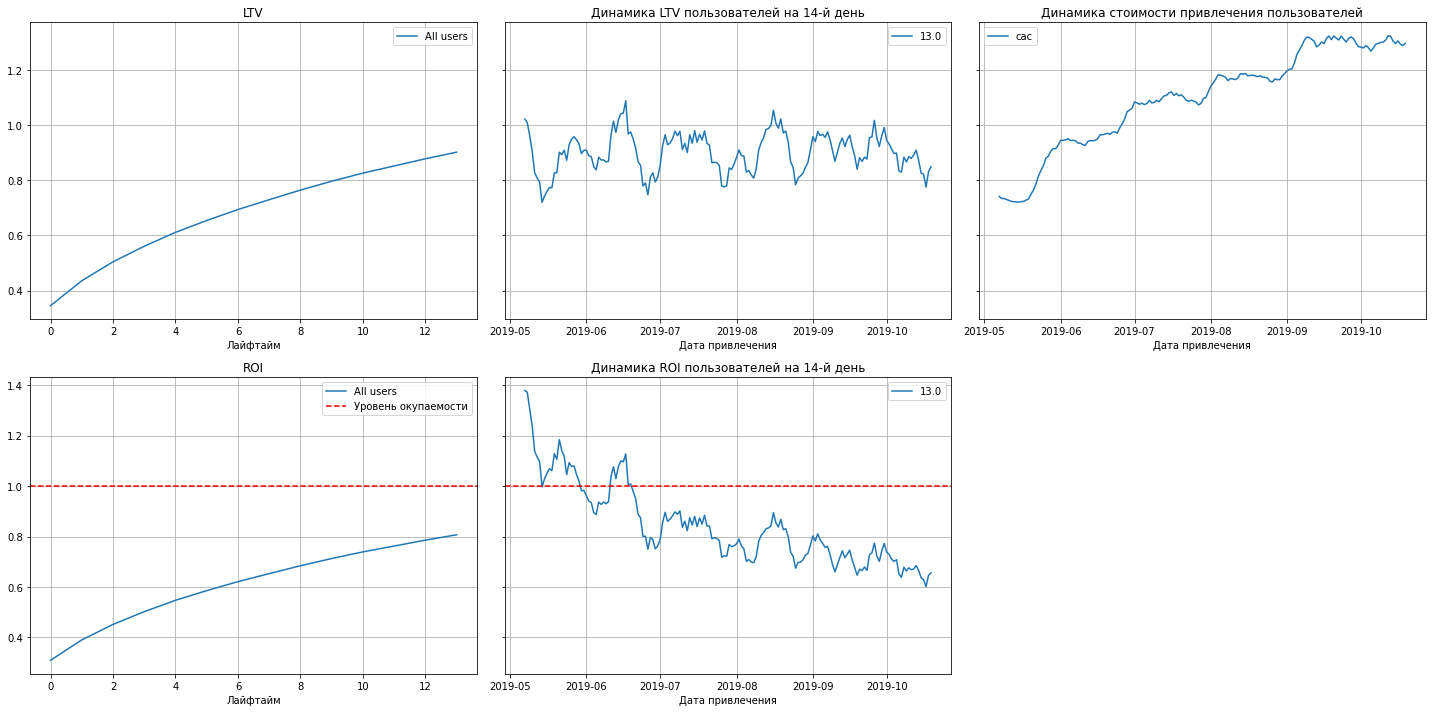

In [27]:
ltv_raw, ltv, ltv_history, roi, roi_history  = get_ltv(
  profiles,
  orders,
  observation_date,
  14,
  dimensions=[],
  ignore_horizon=False)
# таблица LTV
display(ltv)





# строим графики
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14) 

Недельный LTV пользователей составил 54 цента, 14 дневный LTV составил 68 центов. 
Стоимость привлечения растет от мая к октябрю. Затраты на рекламу не окупаются. ROI затрат на привлечение покупателя на 14 день снижается от мая к октябрю и затраты перестают окупаться уже со второй половины июня. 


График динамики ROI показывает, что реклама не окупается. 



Проанализируем окупаемость рекламы с разбивкой по устройствам


### Окупаемость рекламы с разбивкой по устройствам

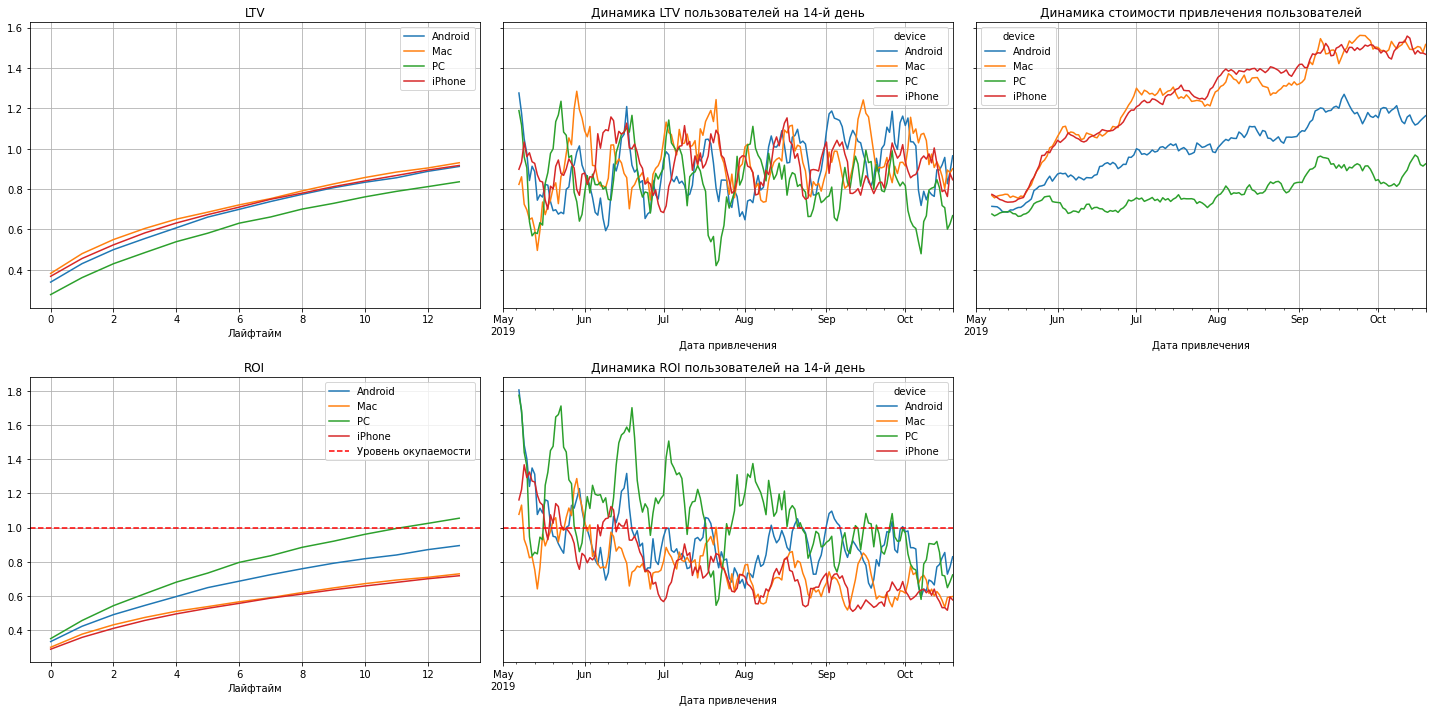

In [28]:
ltv_raw, ltv, ltv_history, roi, roi_history  = get_ltv(
  profiles,
  orders,
  observation_date,
  14,
  dimensions=['device'],
  ignore_horizon=False)
profiles=profiles.query('channel!="organic"')
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14) 

**Вывод:** Самая низкая ROI у пользователей IPhone и Mac, при этом ROI превышает уровень окупаемости только для пользователей PC с мая по сентябрь. ROI пользователей других устройств не превышает уровень окупаемости с августа.

<a id='53'></a>
### Окупаемость рекламы с разбивкой по странам

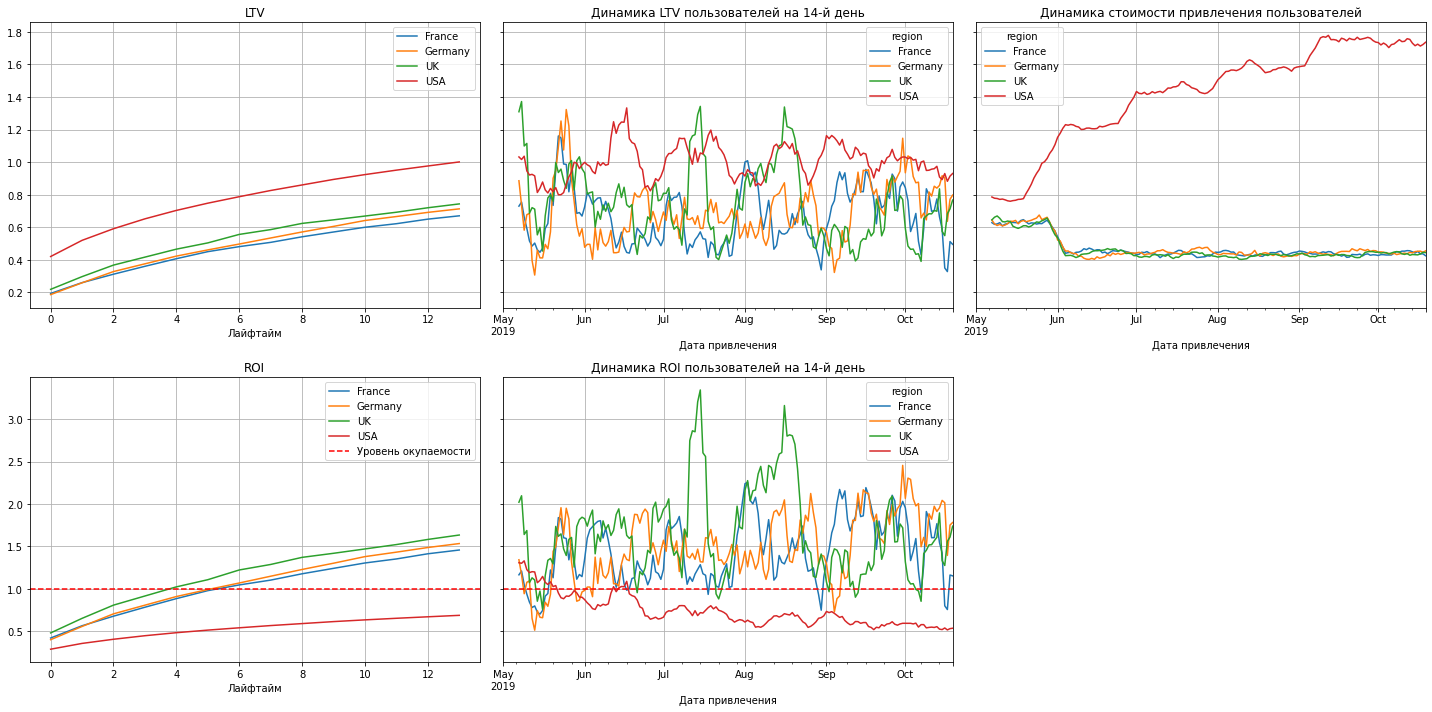

In [29]:
ltv_raw, ltv, ltv_history, roi, roi_history  = get_ltv(
  profiles,
  orders,
  observation_date,
  14,
  dimensions=['region'],
  ignore_horizon=False)
profiles=profiles.query('channel!="organic"')
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14) 

**Вывод:** Единственный регион, где реклама не окупается совсем - США. 


### Окупаемость рекламы с разбивкой по рекламным каналам

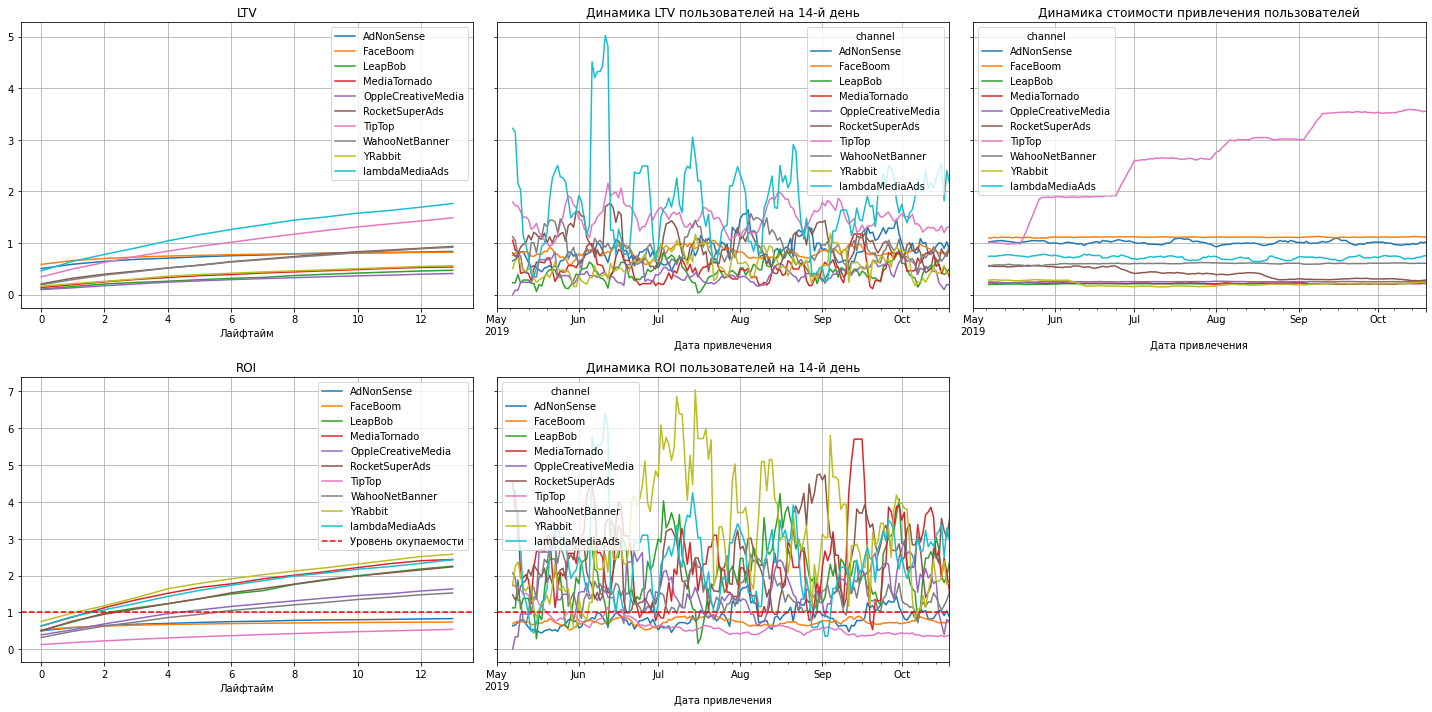

In [30]:
ltv_raw, ltv, ltv_history, roi, roi_history  = get_ltv(
  profiles,
  orders,
  observation_date,
  14,
  dimensions=['channel'],
  ignore_horizon=False)
profiles=profiles.query('channel!="organic"')
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14) 


**Вывод:**  Относительно чаще других окупается реклама на площадках YRabbit и MediaTornado.   Реклама на площадках FaceBoom и TipTop не окупается совсем. 


## Конверсия  с разбивкой по устройствам, странам, рекламным каналам


### Конверсия по устройствам

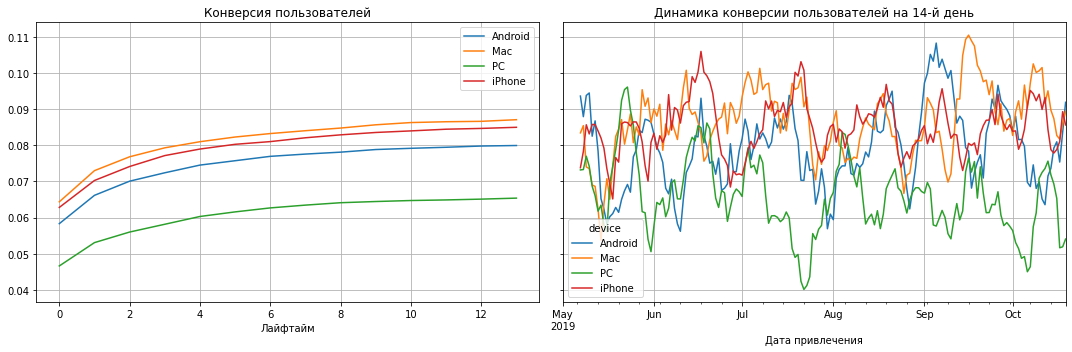

In [31]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles,
    orders,
    observation_date,
    14,
    dimensions=['device'],
    ignore_horizon=False)
plot_conversion(conversion, conversion_history, 14) 

**Вывод:** Двухнедельная конверсия не превышает 7%. Наименьшая конверсия у пользователей РС. Набольшая у пользователей IPhone и Mac.


### Конверсия по регионам

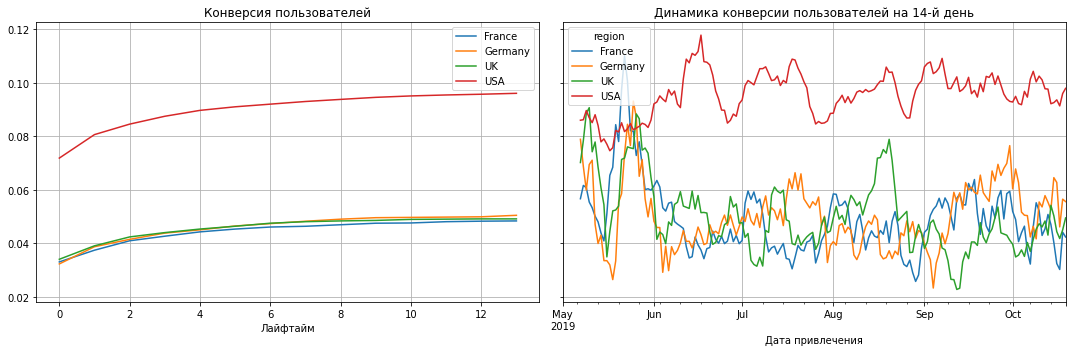

In [32]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles,
    orders,
    observation_date,
    14,
    dimensions=['region'],
    ignore_horizon=False
)
plot_conversion(conversion, conversion_history, 14) 

**Вывод:** Самая высокая конверсия у пользователей в США. Среди пользователей в Европе двухнедельная конверсия не превышает 6%.


### Конверсия по каналам привлечения

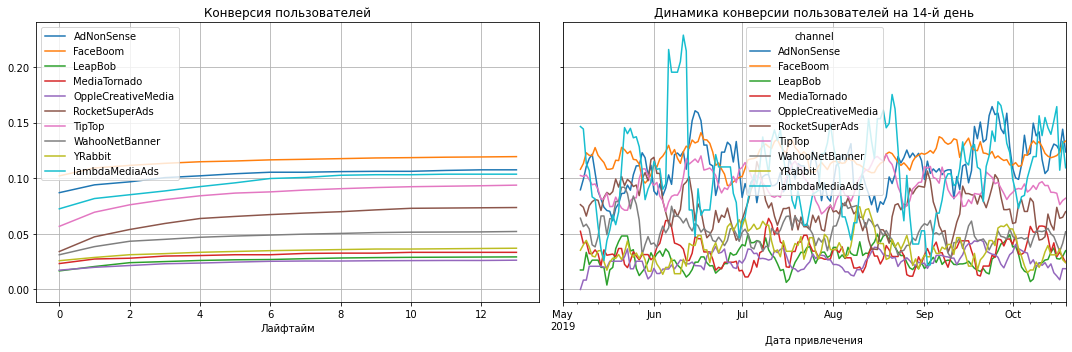

In [33]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles,
    orders,
    observation_date,
    14,
    dimensions=['channel'],
    ignore_horizon=False
)
plot_conversion(conversion, conversion_history, 14) 

**Вывод:**  Самая высокая у пользователей с FaceBoom - 11,9%. Далее по убыванию - AdNonSense - 10,75% и LambdaMediaAds - 10,36%, TipTop - 9,37%.


## Удержание с разбивкой по устройствам, странам, рекламным каналам

<a id='71'></a>
### Удержание по устройствам 

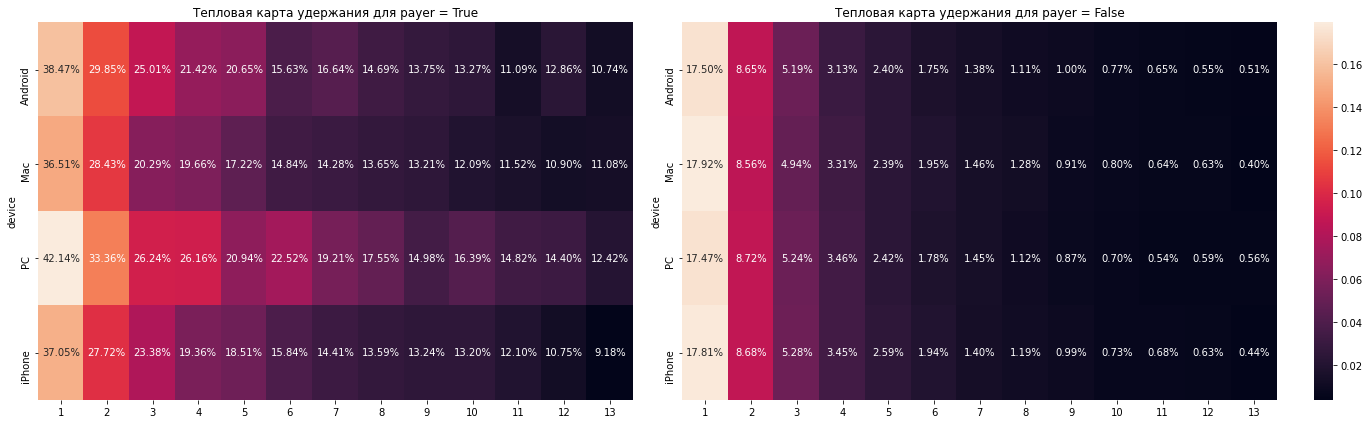

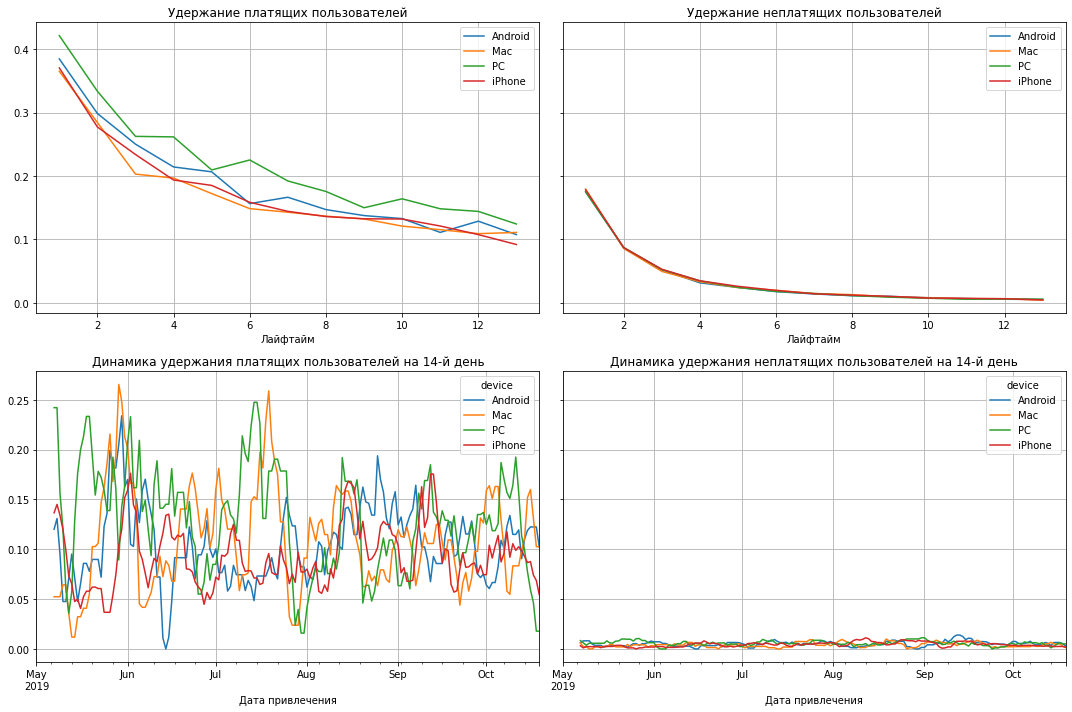

In [34]:

retention_raw, retention, retention_history = get_retention(
    profiles,
    visits,
    observation_date,
    14,
    dimensions=['device']
    ) 

ret('device')
plot_retention(retention, retention_history, 14) 

**Вывод:** Удержание неплатящих пользователей менее 5% уже на 4 день. Среди пользователей, делающих покупки в приложении удержание на 13 день около 10%, снижается равномерно. Удержание платящих пользователей выше у пользователей PS - 12,4%, ниже всего у пользователей iPhone - 9,2%. При этом мы видим  снижение удержания платящих пользователей на Mac и PC с августа. 

### Удержание по регионам

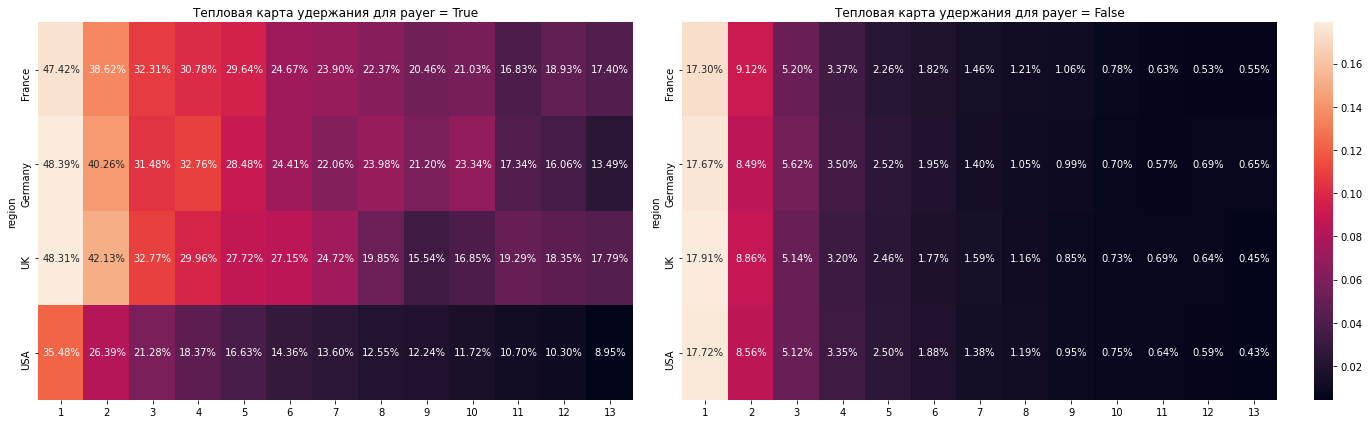

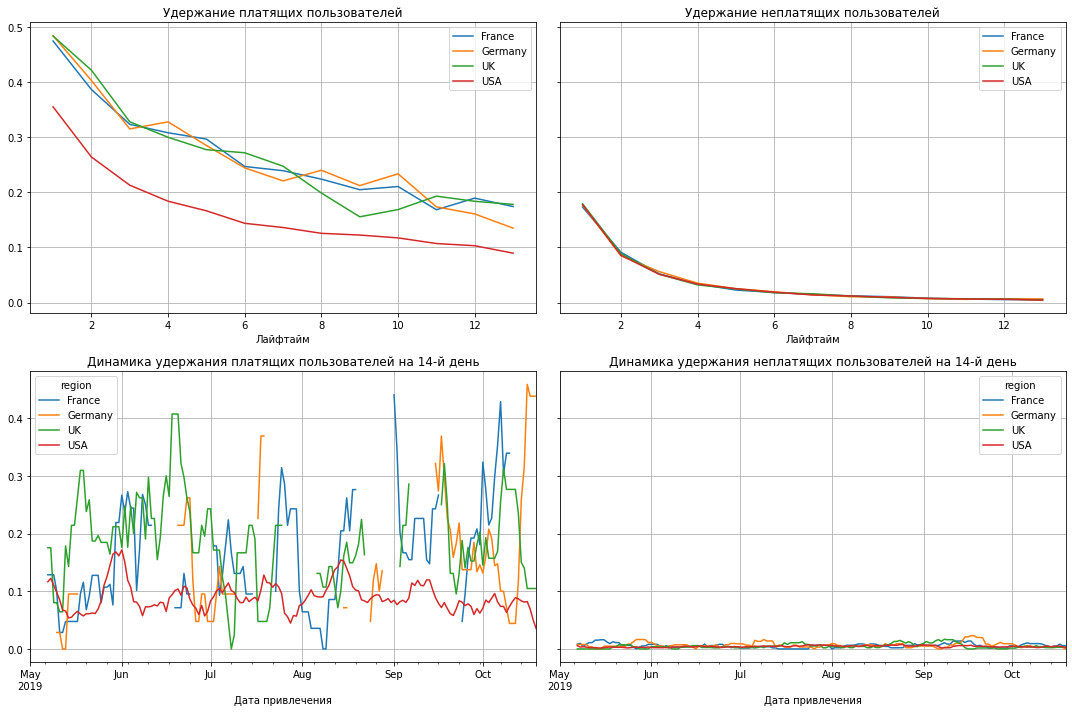

In [35]:
retention_raw, retention, retention_history = get_retention(
    profiles,
    visits,
    observation_date,
    14,
    dimensions=['region']
    )
ret('region')


plot_retention(retention, retention_history, 14) 

**Вывод:**   Наихудшие показателиудержания у пользователей из США - на 14 день продолжают пользоваться приложением всего 9%. Лучший показатель - у покупателей из Великобритании и Франции- 19-20%. 

### Удержание по каналам привлечения

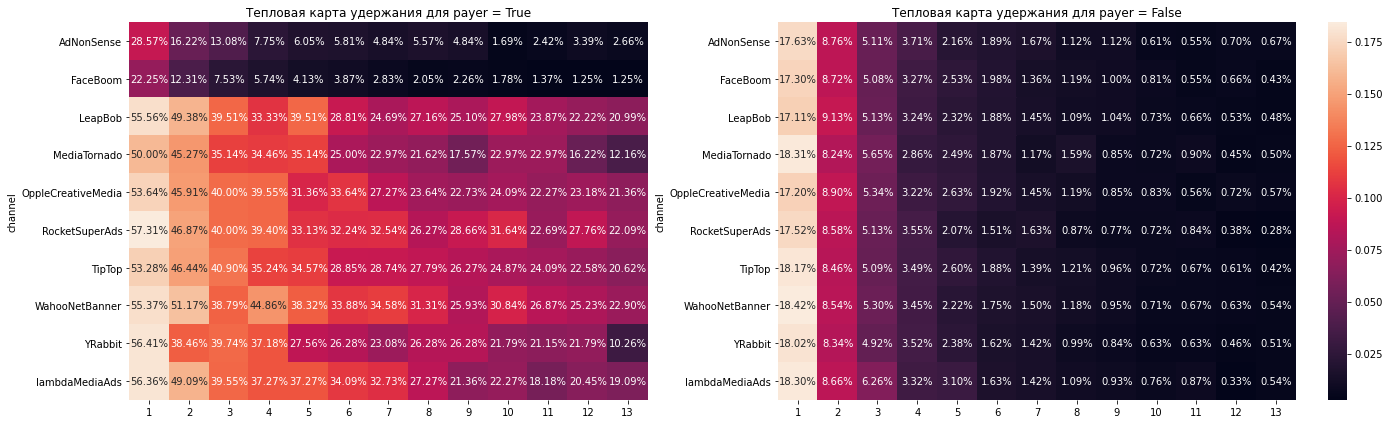

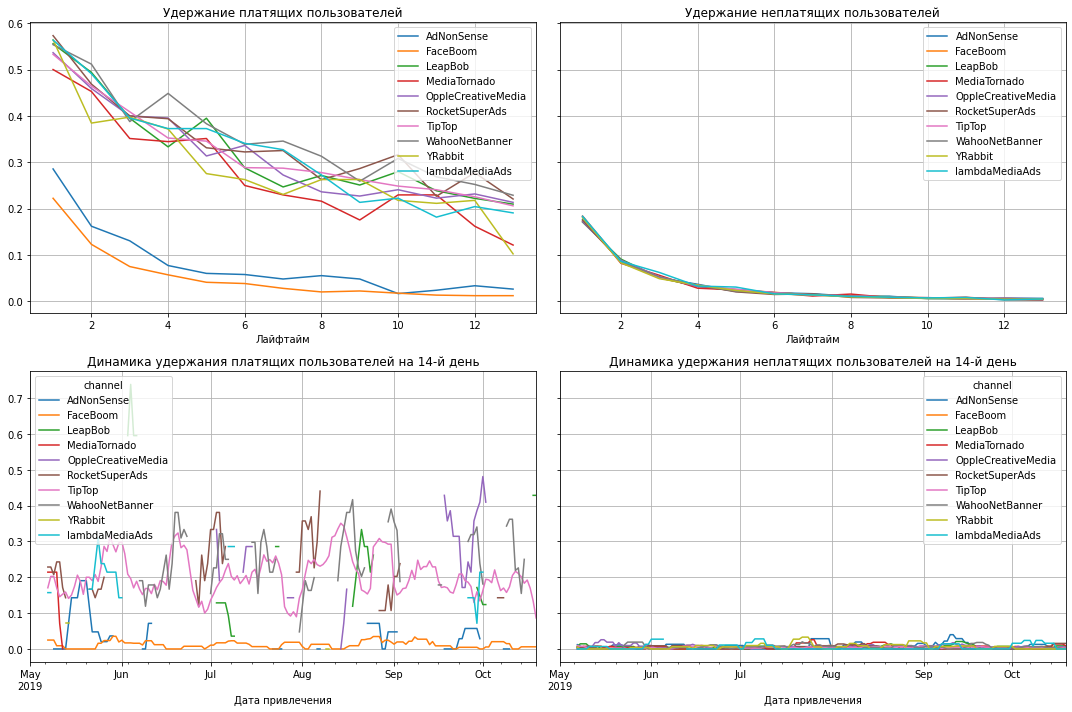

In [36]:
retention_raw, retention, retention_history = get_retention(
    profiles,
    visits,
    observation_date,
    14,
    dimensions=['channel']
    )
ret('channel')
plot_retention(retention, retention_history, 14) 

**Вывод:** Наихудшие показатели удержания у площадок FaceBoom - на 14 день приложением пользуются менее 2% покупателей. Наилучший у WahooNetBanner 22,9%. 

## Выводы
- Выделите причины неэффективности привлечения пользователей;
- Сформируйте рекомендации для отдела маркетинга для повышения эффективности.

1. Основная причина неэффективности привлечения пользователей - не был проведен анализ конверсии и удержания. Например, деньги вкладывались в рекламу на площадки FaceBoom (вторая по затрам на рекламу) с наименьшими показателями удержания. Так же обращают на себя внимание в целом невысокие показатели удержания для приложения, особенно для пользователей на iPhone и MAC. 

2. Необходимо детально изучить маркетинговую воронку и выяснить причины низкой конверсии (на каком этапе происходит сбой). 

3. Если это не сделано ранее, возможно введение в приложение функции с запросом на обратную связь от пользователя при попытке удалить приложение или длительном его неиспользовании с целью выяснения причин низкого удержания. 

4. Также опрометчиво было увеличивать затраты на рекламу в FaceBoom и TipTop, не оценив ее окупаемость на этих площадках. За все время наблюдения реклама на этих площадках не окупилась ни разу. 

5. Можно предположить, что в августе произошли события, повлиявшие на снижение конверсии и удержания у пользователей Mac и iPhone. Необходимо выяснить, не изменилось ли что-нибудь в приложении для пользователей этих устройств. 